## A little More on PyMC3

In [55]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.size': 10, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

## Model context

All variables we want in our model are defined within the Model context/object.  
If you try to define a variable outside of the Model context, you will ge an error.

### Initial values
All variables in the Model context have initial values i.e test value. It's used as the starting point for sampling if no other start is specified.

In [2]:
with pm.Model() as model:
    param = pm.Exponential("param", lam = 1)
    data_gen = pm.Poisson("data_gen", mu = param)

In [3]:
param.tag.test_value

array(0.6931471824645996)

In [4]:
data_gen.tag.test_value

0

Supply initial values using testval. This maybe necessary if you need a better starting point

In [5]:
with pm.Model() as model:
    param = pm.Exponential("param", lam = 1, testval = 0.4)
    
param.tag.test_value    

array(0.4)

Use the *shape* argument to specify the number of variables like number of coefficients

In [14]:
number_of_coeff = 5
with pm.Model() as model:
    betas = pm.Normal("betas", mu = 0, sd = 1, shape = number_of_coeff)

betas.tag.test_value    

array([ 0.,  0.,  0.,  0.,  0.])

In [7]:
X = np.array(sns.load_dataset("tips")[["total_bill", "tip"]])

If we want a deterministic variable to be tracked by our sampling, define it explicitly using the *deterministic* constructor

In [9]:
X = sns.load_dataset("tips")[["total_bill", "tip"]]
with pm.Model() as model:
    betas = pm.Normal("betas", mu = 0, sd = 1, shape = 2)
    sd_error = pm.HalfNormal("sd_error", sd = 1)
    intercept = pm.Normal("intercept", mu = 0, sd = 1)
    
    # specify the mean function
    mean = pm.Deterministic("mean", intercept + betas * X)

## Theano 

1. Most of the heavy lifting in PyMC3 is done by *theano*.
2. Theano build a "compute graph" that tracks your operations on data.
3. Theano is lazy evaluated, only when you eval is the compute graph evaluated.

Advantages of computing graphs
1. compute gradients via autodiff
2. compile the graph to C to run at machine speed
3. compile the graph to run on GPUs

## Review the priors

In [32]:
beta_samples = [betas.random() for i in range(100)]

In [33]:
beta_samples = pd.DataFrame(beta_samples)

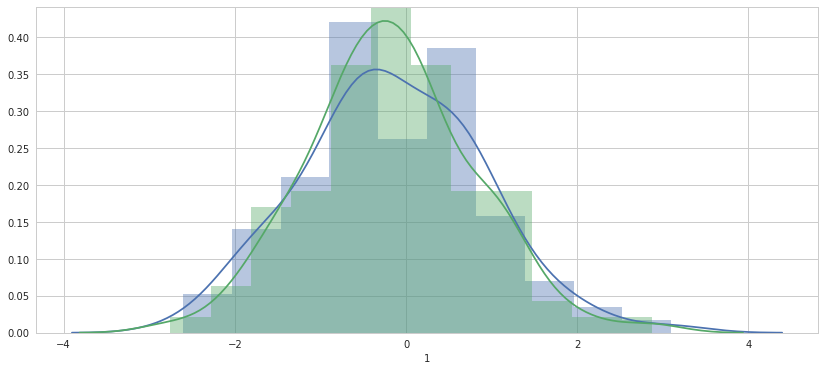

In [34]:
sns.distplot(beta_samples[0])
sns.distplot(beta_samples[1])

## Simulate possible data from model

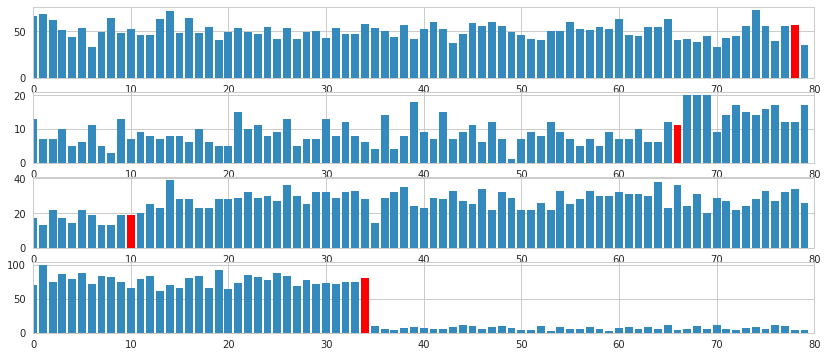

In [45]:
import scipy.stats as stats
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="user behaviour changed")
    plt.xlim(0, 80);
    
plt.title("More example of artificial datasets")    
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()

## A/B testing

It is determining the difference in effectiveness between two treatments

In [110]:
# simulate fake data
p_true = 0.05
N = 10000
data = stats.bernoulli.rvs(p = p_true, size = N)
data

array([0, 1, 0, ..., 0, 0, 0])

In [120]:
# build the model
with pm.Model() as ab_test_model:
    
    # specify the prior
    alpha = pm.HalfNormal("alpha", sd = 0.5)
    beta = pm.HalfNormal("beta", sd = 3)
    p = pm.Beta("p", alpha = alpha, beta = beta)
    
    # specify the likelihood
    obs = pm.Bernoulli("obs", p = p, observed = data)

In [121]:
# sample from the model
with ab_test_model:
    step = pm.NUTS(target_accept = 0.99)
    posterior = pm.sample(draws = 20000, njobs = 2, tune = 1000, step = step)

100%|██████████| 21000/21000 [02:04<00:00, 168.90it/s]


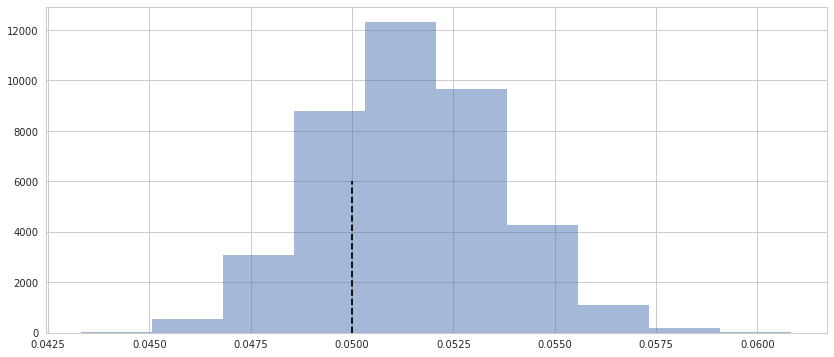

In [122]:
fig, ax = plt.subplots()
ax.hist(x = posterior["p"], alpha = 0.5)
ax.vlines(ymin = 0, ymax = 6000, x = p_true, linestyles = "--")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f145266aa90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1450e99d30>]], dtype=object)

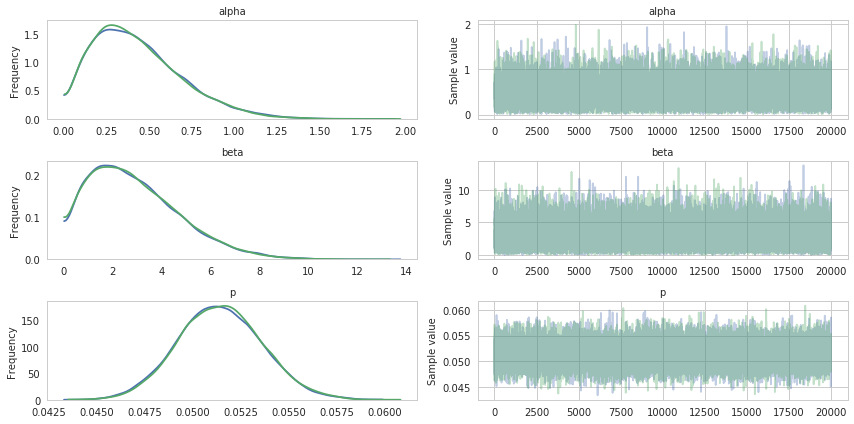

In [123]:
pm.traceplot(posterior)

In [124]:
pm.gelman_rubin(posterior)

{'alpha': 1.0000432631747826,
 'beta': 0.99999899716973129,
 'p': 1.000001390454468}

In [135]:
# simulate fake data
true_p_A = 0.05
true_p_B = 0.04
N_A = 50000
N_B = 500
data_A = stats.bernoulli.rvs(p = true_p_A, size = N_A)
data_B = stats.bernoulli.rvs(p = true_p_B, size = N_B)

In [136]:
with pm.Model() as ab_diff_model:
    
    #specifity prior
    alpha = pm.HalfNormal("alpha", sd = 5)
    beta = pm.HalfNormal("beta", sd = 3)
    p_A = pm.Beta("p_A", alpha = alpha, beta = beta)
    p_B = pm.Beta("p_B", alpha = alpha, beta = beta)
    
    # specify the difference in proportions
    diff = pm.Deterministic("diff", p_A - p_B)
    
    # specify the likelihoods
    obs_A = pm.Bernoulli("obs_A", p = p_A, observed = data_A)
    obs_B = pm.Bernoulli("obs_B", p = p_B, observed = data_B)

INFO (theano.gof.compilelock): Refreshing lock /home/emaasit/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.3.1611-Core-x86_64-3.6.3-64/lock_dir/lock


In [143]:
# sample from the posterior
with ab_diff_model:
    step = pm.NUTS(target_accept = 0.9)
    posterior = pm.sample(draws = 10000, njobs = 2, tune = 1000, step = step, progressbar = False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f144e3f4eb8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1452666eb8>], dtype=object)

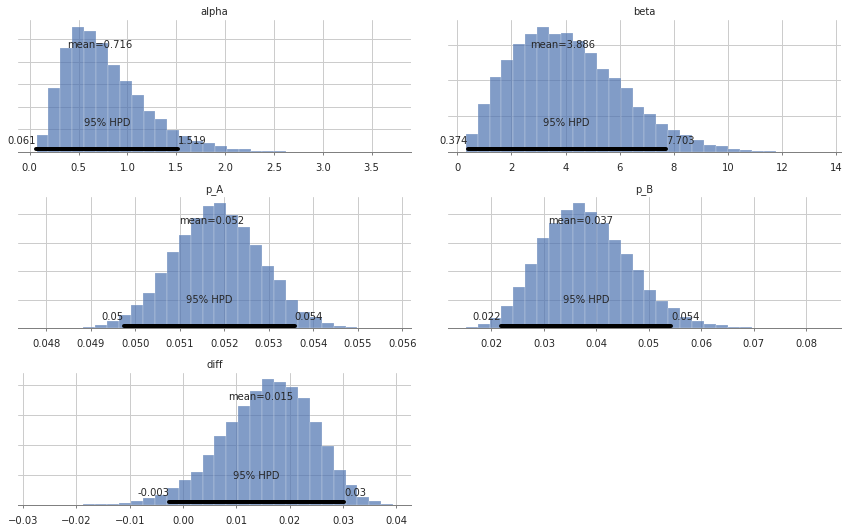

In [141]:
pm.plot_posterior(posterior, alpha = 0.7)

## More PyMC3 tricks

In [7]:
# arrays of multiple PyMC variables
N= 50
x = np.ones(N, dtype = object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential("x_%i" % i, lam = (i + 1)**2)

In [8]:
x

array([x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12,
       x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20, x_21, x_22, x_23,
       x_24, x_25, x_26, x_27, x_28, x_29, x_30, x_31, x_32, x_33, x_34,
       x_35, x_36, x_37, x_38, x_39, x_40, x_41, x_42, x_43, x_44, x_45,
       x_46, x_47, x_48, x_49], dtype=object)

### Challenger disaster

### Step 1: Prepare the data

In [47]:
path = "https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv"
data = pd.read_csv(path).dropna()
data = data[~data["Damage Incident"].str.contains("Challe")]
data.head()

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0


Text(0,0.5,'Probability')

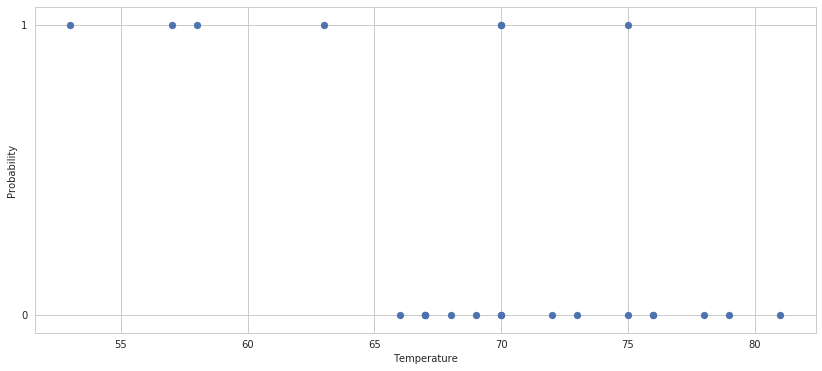

In [45]:
fig, ax = plt.subplots()
ax.scatter(x = "Temperature", y = "Damage Incident", data = data)
ax.set_xlabel("Temperature")
ax.set_ylabel("Probability")

In [50]:
temp = data["Temperature"]
damage = data["Damage Incident"]

### Step 2: Build the model

In [72]:
with pm.Model() as model:
    
    # specify the prior
    beta = pm.Normal("beta", mu = 0, tau = 0.001)
    alpha = pm.Normal("alpha", mu = 0, tau = 0.001)
    p = pm.Deterministic("p", 1.0/(1.0 + tt.exp(beta * temp + alpha)))
    
    # specify the likelihood
    obs = pm.Bernoulli("obs", p = p, observed = damage)
    
    # simulate data from model
    simulated_obs = pm.Bernoulli("simulated_obs", p = p, shape = p.tag.test_value.shape)

### Step 3: Sample from the posterior

In [73]:
with model:
    step = pm.NUTS(target_accept = 0.9)
    posterior = pm.sample(draws = 5000, njobs = 4, tune = 1000, step = step)

Assigned BinaryGibbsMetropolis to simulated_obs
100%|██████████| 6000/6000 [01:20<00:00, 74.56it/s]


### Step 4: Diagnose convergence of MCMC chains

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56600900b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5660009358>]], dtype=object)

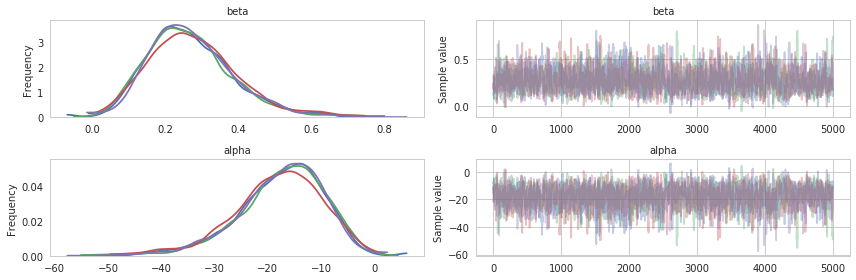

In [74]:
pm.traceplot(posterior, varnames = ["beta", "alpha"])

In [75]:
pm.gelman_rubin(posterior)

{'alpha': 1.0010275925753087,
 'beta': 1.0010213889768667,
 'p': array([ 1.00012707,  0.99998635,  0.99993546,  0.99993097,  0.9999945 ,
         1.0001366 ,  1.00020424,  0.99998635,  1.0006562 ,  1.00059688,
         0.99998635,  1.00029093,  0.9999945 ,  1.0004995 ,  0.9999945 ,
         1.00028833,  0.99998635,  1.00021236,  1.00030332,  1.00026992,
         1.00028833,  1.00030332,  1.00069382]),
 'simulated_obs': array([ 0.99991268,  0.99991462,  0.99993184,  0.99990806,  0.99990965,
         0.99994955,  0.99994514,  0.99992675,  1.00014196,  1.00008823,
         0.99991197,  0.99997257,  0.99996806,  1.00003009,  0.99996119,
         1.00005338,  1.00000379,  0.99995997,  0.99997647,  1.00006685,
         0.99998241,  1.0001335 ,  1.00006207])}

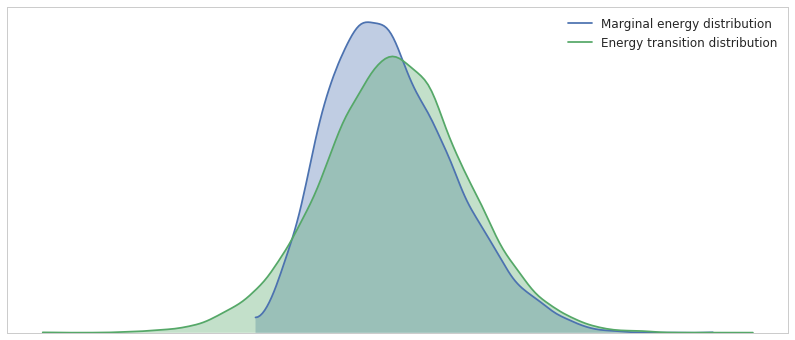

In [76]:
pm.energyplot(posterior)

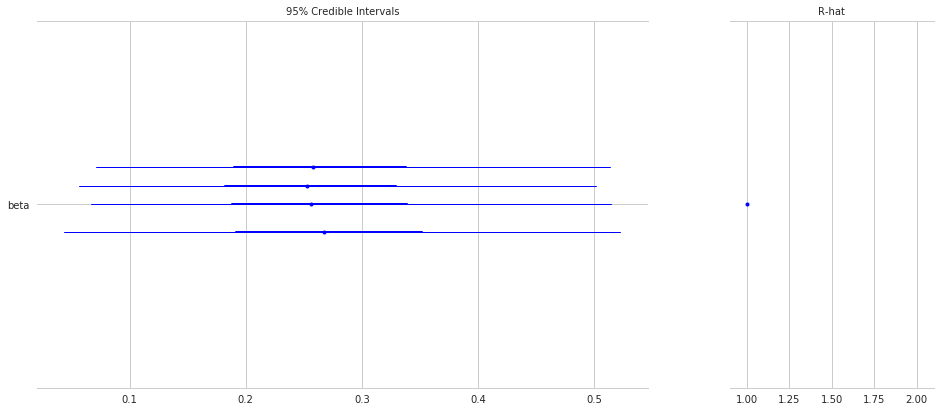

In [77]:
pm.forestplot(posterior, varnames = ["beta"])

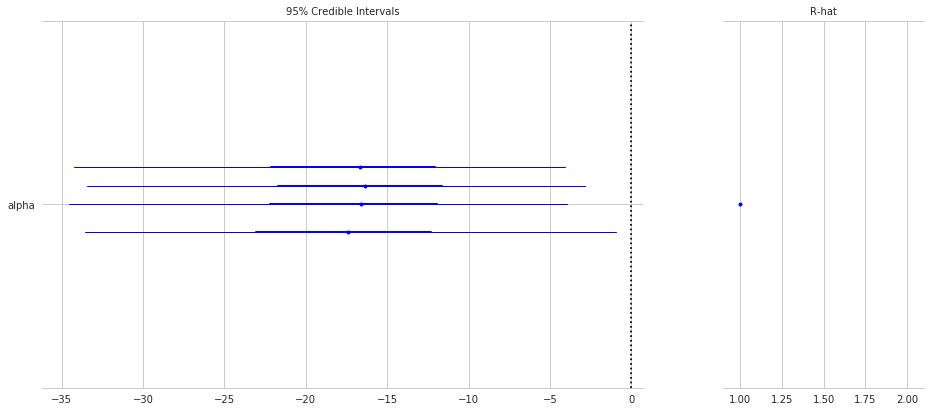

In [78]:
pm.forestplot(posterior, varnames = [ "alpha"])

### Step 5: Criticize the model

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f565fdc76d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f565fd21b38>], dtype=object)

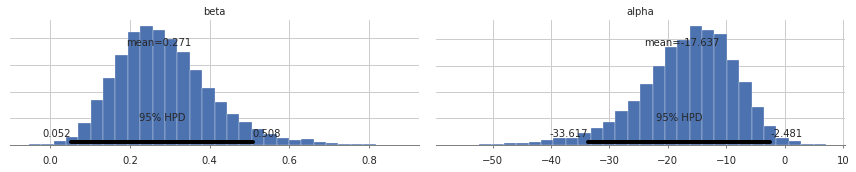

In [79]:
pm.plot_posterior(posterior, varnames = ["beta", "alpha"])

In [80]:
pm.summary(posterior)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.271177,0.119499,0.002709,0.051816,0.508054,1522.0,1.001021
alpha,-17.636657,8.131190,0.184294,-33.617335,-2.481097,1518.0,1.001028
simulated_obs__0,0.440500,0.496447,0.002469,0.000000,1.000000,20000.0,0.999913
simulated_obs__1,0.223700,0.416723,0.002358,0.000000,1.000000,20000.0,0.999915
simulated_obs__2,0.268750,0.443310,0.002187,0.000000,1.000000,20000.0,0.999932
simulated_obs__3,0.322000,0.467243,0.002369,0.000000,1.000000,20000.0,0.999908
simulated_obs__4,0.379100,0.485163,0.002258,0.000000,1.000000,20000.0,0.999910
simulated_obs__5,0.153650,0.360613,0.002518,0.000000,1.000000,20000.0,0.999950
simulated_obs__6,0.130000,0.336303,0.002465,0.000000,1.000000,20000.0,0.999945
simulated_obs__7,0.224550,0.417286,0.002471,0.000000,1.000000,20000.0,0.999927


In [81]:
# extract the simulated data
simulated_data = posterior["simulated_obs"]
simulated_data.shape

(20000, 23)

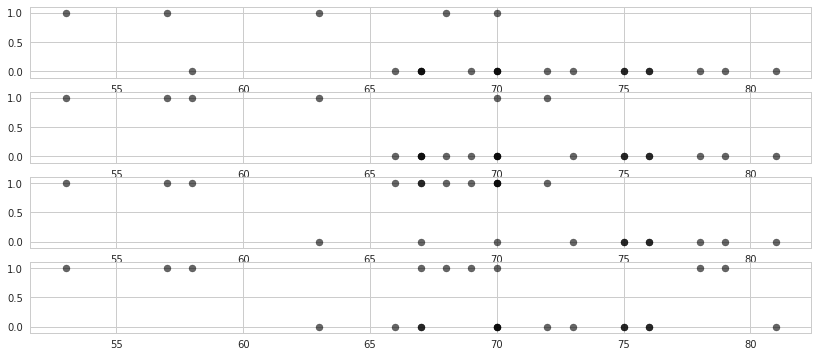

In [86]:
plt.title("Simulated dataset using posterior parameters")
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temp, simulated_data[1000*i, :], color="k",
                s=50, alpha=0.6)